In [1]:
# =========================
# 1. IMPORT LIBRARIES
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

In [ ]:
# =========================
# 2. LOAD DATA
# =========================
from dotenv import load_dotenv
import os
load_dotenv()
data_path = os.getenv("PATH")
df = pd.read_csv(data_path, index_col="PassengerId")


In [3]:
# =========================
# 3. HANDLE MISSING VALUES
# =========================

df["Age"] = df["Age"].fillna(df["Age"].mean())

df["Fare"] = pd.to_numeric(df["Fare"], errors="coerce")
df["Fare"] = df["Fare"].fillna(df["Fare"].median())

df["Sex"] = df["Sex"].fillna(df["Sex"].mode()[0])
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# Cabin → Deck extraction
df["Deck"] = df["Cabin"].str[0]
df["Deck"] = df["Deck"].fillna("Missing")
df.drop(columns=["Cabin"], inplace=True)

In [4]:

# =========================
# 4. ENCODING
# =========================
df_copy = df.copy()

# Label encode Sex
le = LabelEncoder()
df_copy["Sex_encoded"] = le.fit_transform(df_copy["Sex"])
df_copy.drop(columns=["Sex"], inplace=True)

# One-hot encode Embarked
df_copy = pd.get_dummies(df_copy, columns=["Embarked"], drop_first=True)


In [ ]:
# =========================
# 5. DROP STRING COLUMNS
# =========================
df_copy.drop(columns=["Name", "Ticket"], inplace=True)

# Converting to numeric types from object 
df_copy["Pclass"] = pd.to_numeric(df_copy["Pclass"], errors="coerce")
df_copy["Parch"] = pd.to_numeric(df_copy["Parch"], errors="coerce")

In [14]:
# =========================
# 6. SELECT FEATURES & TARGET
# =========================
X = df_copy[
    ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_encoded", "Embarked_Q", "Embarked_S"]
]

y = df_copy["Survived"]

# Handle remaining NaNs safely
X = X.dropna()
y = y.loc[X.index]

In [15]:
# =========================
# 7. TRAIN TEST SPLIT
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X.dtypes)

Pclass         float64
Age            float64
SibSp            int64
Parch          float64
Fare           float64
Sex_encoded      int64
Embarked_Q        bool
Embarked_S        bool
dtype: object


In [16]:

# =========================
# 8. GRADIENT BOOSTING MODEL
# =========================
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

gb_model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.05
,n_estimators,200
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [ ]:
# 9. PREDICTION
# =========================
y_pred = gb_model.predict(X_test)
y_prob = gb_model.predict_proba(X_test)[:, 1]  # gives the probability for class label ie for 0,1 -> [0.85,0.15]

In [18]:
# =========================
# 10. METRICS
# =========================
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_prob))

Accuracy : 0.8156424581005587
Precision: 0.8153846153846154
Recall   : 0.7162162162162162
F1 Score : 0.762589928057554
ROC AUC  : 0.8853281853281852


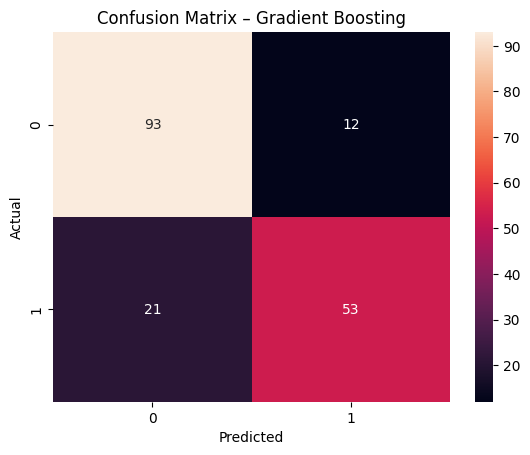

In [19]:
cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Gradient Boosting")
plt.show()


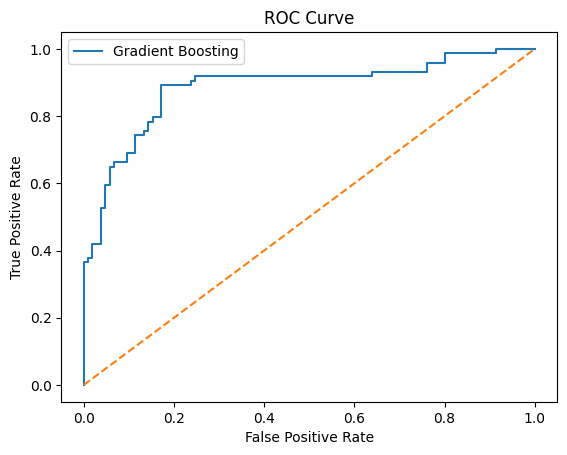

In [20]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label="Gradient Boosting")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


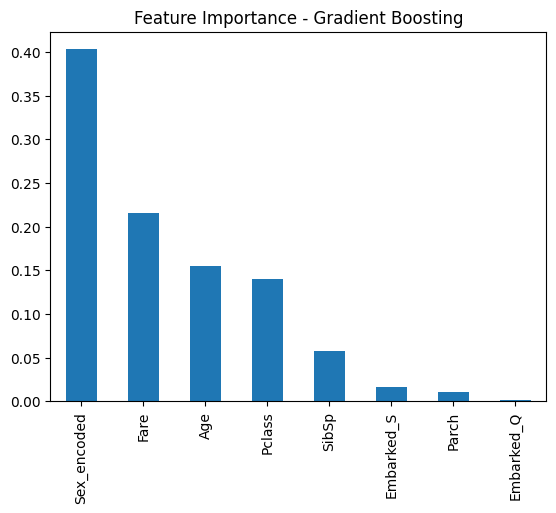

In [ ]:
feature_importance = pd.Series(
    gb_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure()
feature_importance.plot(kind="bar")
plt.title("Feature Importance - Gradient Boosting")
plt.show()
